In [1]:
model_checkpoint = "google/vit-base-patch16-224-in21k" # pre-trained model from which to fine-tune
batch_size = 32 # batch size for training and evaluation

In [2]:
!pip install -q datasets transformers

In [3]:
from huggingface_hub import notebook_login

notebook_login()

In [4]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [5]:
from transformers.utils import send_example_telemetry

send_example_telemetry("image_classification_notebook", framework="pytorch")

### Loading the dataset

In [6]:
from datasets import load_dataset 

# load a custom dataset from local/remote files or folders using the ImageFolder feature

dataset = load_dataset("imagefolder", data_dir="/kaggle/input/mmds-cxr-ii", split="train")
dataset = dataset.train_test_split(test_size=0.2)

Resolving data files:   0%|          | 0/15159 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset image_folder downloaded and prepared to /root/.cache/huggingface/datasets/image_folder/default-7fe929430e989a7d/0.0.0/ee92df8e96c6907f3c851a987be3fd03d4b93b247e727b69a8e23ac94392a091. Subsequent calls will reuse this data.


In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 12127
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 3032
    })
})

In [8]:
from datasets import load_metric

metric = load_metric("accuracy")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [9]:
example = dataset["train"][10]
example

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=1024x1024>,
 'label': 0}

In [10]:
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(num_classes=3, names=['0-Normal', '1-Pneumonia', '2-COVID19'], id=None)}

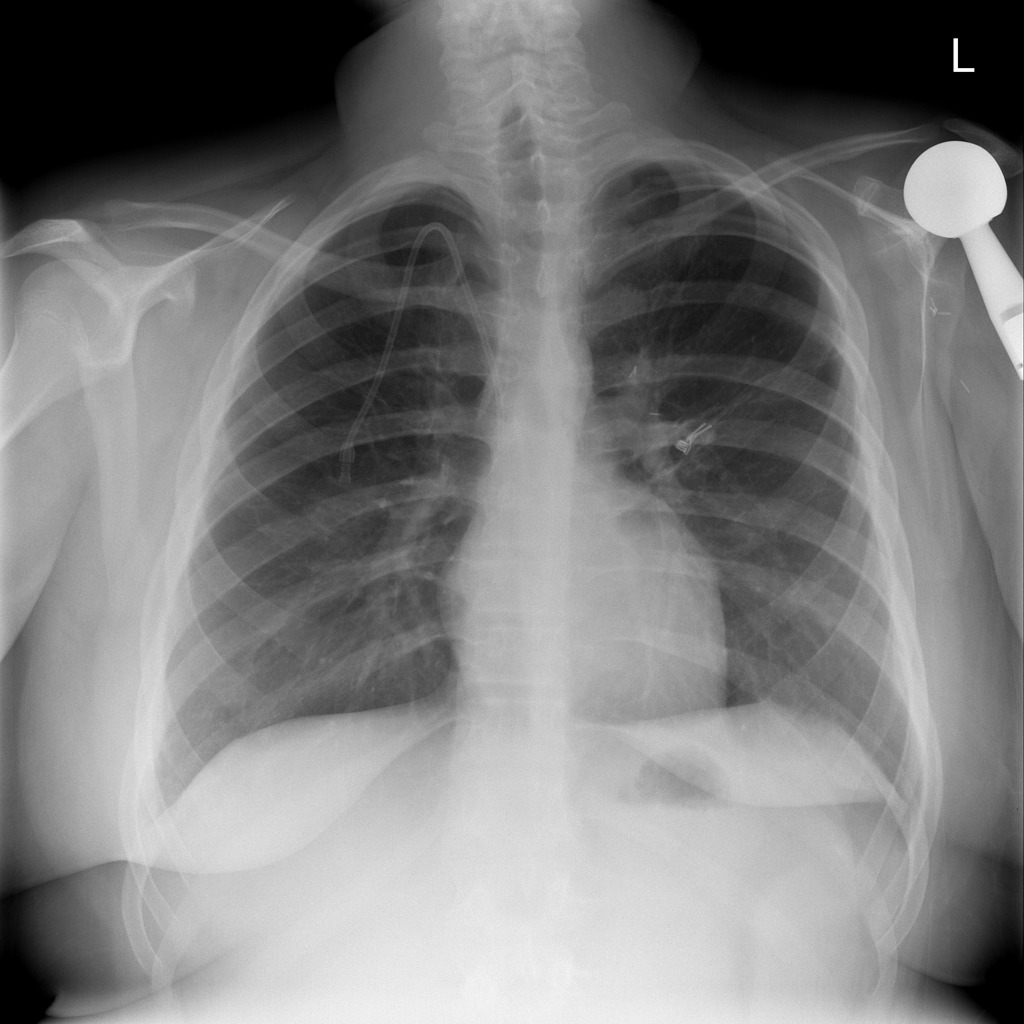

In [11]:
example['image']

In [12]:
example['label']

0

In [13]:
dataset["train"].features["label"]

ClassLabel(num_classes=3, names=['0-Normal', '1-Pneumonia', '2-COVID19'], id=None)

In [14]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[2]

'2-COVID19'

### Preprocessing the data

In [15]:
from transformers import AutoImageProcessor

image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor 

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [16]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [
        val_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

In [17]:
# split up training into training + validation
splits = dataset["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

In [18]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [19]:
train_ds[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=1024x1024>,
 'label': 0,
 'pixel_values': tensor([[[-0.9451, -0.9451, -0.9451,  ..., -0.9686, -0.9686, -0.9686],
          [-0.9451, -0.9451, -0.9451,  ..., -0.9686, -0.9686, -0.9686],
          [-0.9529, -0.9451, -0.9451,  ..., -0.9686, -0.9686, -0.9686],
          ...,
          [ 0.1843,  0.2000,  0.2078,  ...,  0.1059,  0.0902,  0.0667],
          [ 0.2000,  0.2078,  0.2157,  ...,  0.1059,  0.0902,  0.0667],
          [ 0.2000,  0.2157,  0.2157,  ...,  0.1059,  0.0902,  0.0667]],
 
         [[-0.9451, -0.9451, -0.9451,  ..., -0.9686, -0.9686, -0.9686],
          [-0.9451, -0.9451, -0.9451,  ..., -0.9686, -0.9686, -0.9686],
          [-0.9529, -0.9451, -0.9451,  ..., -0.9686, -0.9686, -0.9686],
          ...,
          [ 0.1843,  0.2000,  0.2078,  ...,  0.1059,  0.0902,  0.0667],
          [ 0.2000,  0.2078,  0.2157,  ...,  0.1059,  0.0902,  0.0667],
          [ 0.2000,  0.2157,  0.2157,  ...,  0.1059,  0.0902,  0.0667]],


### Training the model

In [20]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)


pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-cxr",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=15,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

In [28]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [29]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [30]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [31]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Epoch,Training Loss,Validation Loss,Accuracy
0,0.299400,0.333693,0.885408
2,0.251900,0.249481,0.913438
4,0.209400,0.210543,0.925804
6,0.195900,0.202164,0.925804
8,0.191500,0.188868,0.930750
10,0.174000,0.187239,0.932399
12,0.140800,0.189047,0.934872
14,0.166100,0.187930,0.926628


Checkpoint destination directory vit-base-patch16-224-in21k-finetuned-cxr/checkpoint-85 already exists and is non-empty.Saving will proceed but saved results may be invalid.


***** train metrics *****
  epoch                    =         14.91
  total_flos               = 11747944286GF
  train_loss               =        0.2097
  train_runtime            =    1:45:12.12
  train_samples_per_second =        25.936
  train_steps_per_second   =         0.202


In [32]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =      14.91
  eval_accuracy           =     0.9357
  eval_loss               =     0.1758
  eval_runtime            = 0:00:30.58
  eval_samples_per_second =     39.658
  eval_steps_per_second   =      1.242


In [33]:
trainer.push_to_hub()

events.out.tfevents.1703490115.9c5d3a76b6da.42.2:   0%|          | 0.00/411 [00:00<?, ?B/s]

'https://huggingface.co/saileshaman/vit-base-patch16-224-in21k-finetuned-cxr/tree/main/'

## Inference

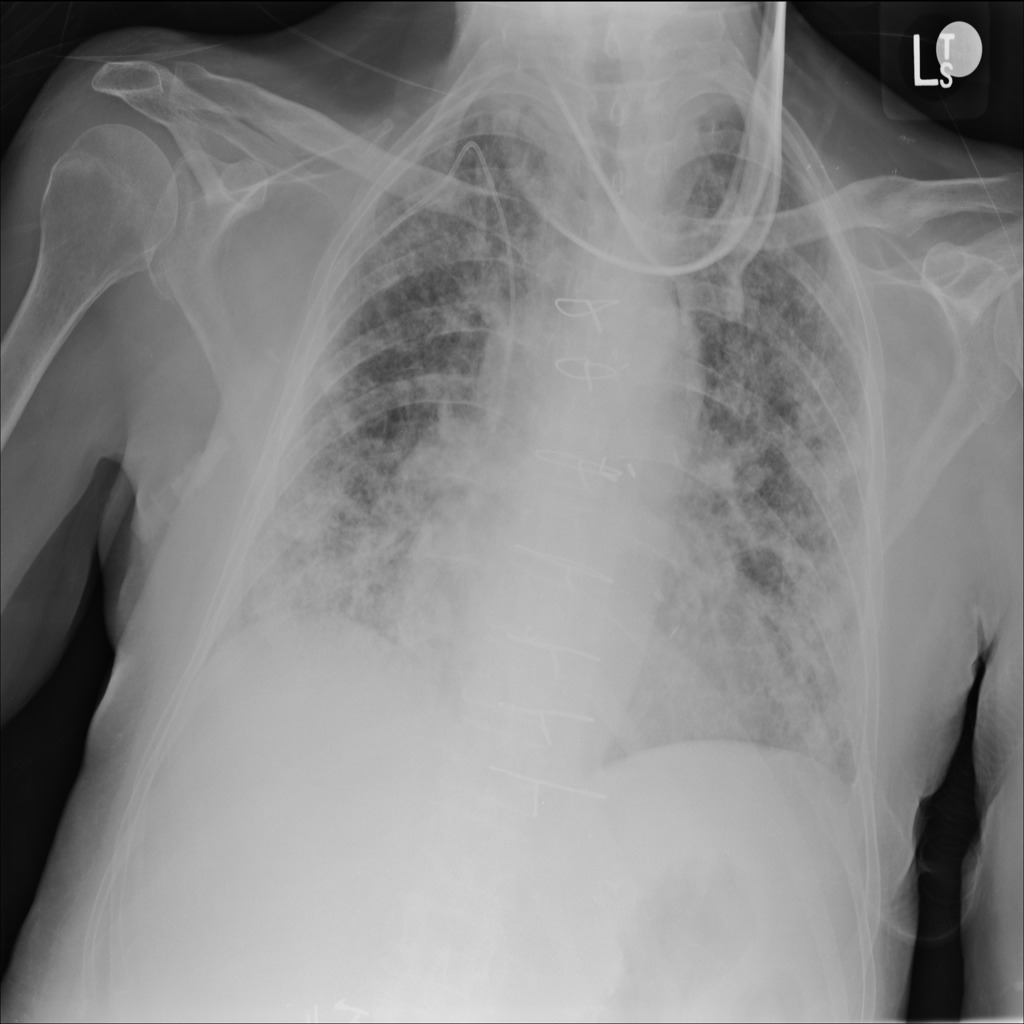

In [39]:
from PIL import Image
import requests

file = "/kaggle/input/mmds-cxr-ii/test/1-Pneumonia/05d3817a-5535-4e77-8dda-d4412e496c81.png"
image = Image.open(file)
image

In [40]:
from transformers import AutoModelForImageClassification, AutoImageProcessor

repo_name = "saileshaman/vit-base-patch16-224-in21k-finetuned-cxr"

image_processor = AutoImageProcessor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)

In [41]:
# prepare image for the model
encoding = image_processor(image.convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)

torch.Size([1, 3, 224, 224])


In [42]:
import torch

# forward pass
with torch.no_grad():
    outputs = model(**encoding)
    logits = outputs.logits

In [43]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: 1-Pneumonia


## Pipeline API

In [48]:
from transformers import pipeline

pipe = pipeline("image-classification", "saileshaman/vit-base-patch16-224-in21k-finetuned-cxr")

In [45]:
pipe(image)

[{'score': 0.989981472492218, 'label': '1-Pneumonia'},
 {'score': 0.005542520433664322, 'label': '2-COVID19'},
 {'score': 0.004475900437682867, 'label': '0-Normal'}]

In [46]:
pipe = pipeline("image-classification", 
                model=model,
                feature_extractor=image_processor)

In [47]:
pipe(image)

[{'score': 0.989981472492218, 'label': '1-Pneumonia'},
 {'score': 0.005542520433664322, 'label': '2-COVID19'},
 {'score': 0.004475900437682867, 'label': '0-Normal'}]